In [1]:
import os
import time
import sklearn
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn import metrics, cross_validation

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

In [3]:
time.asctime()

'Sun Apr 23 19:57:56 2017'

In [4]:
df = pd.read_csv(os.path.expanduser('/Users/cthoyt/Downloads/esrd_timeseries_admit_comorbidities9_10_all.csv'))

In [5]:
df.head()

,Unnamed: 0,pie.id,timedelta,creatinine,clearance,Contrast_volume,PCI_type,Stents,Prehydration,Posthydration,...,Hypertension,CKD,Afib,COPD,CAD,Diabetes,HF,STEMI,NSTEMI,VFIB
0,3,121870698,0 days 12:39:00,1.4,38.609127,100,LM,1,1086.0,2974,...,True,True,False,True,True,False,True,N,N,N
1,5,121897939,0 days 12:47:00,1.1,52.579545,50,LM,2,750.0,700,...,True,False,False,False,True,True,False,N,N,N
2,6,121912882,0 days 11:31:00,0.8,73.671875,200,LAD,3,240.0,1000,...,True,False,False,False,True,False,False,N,N,N
3,7,121919846,0 days 01:10:00,1.4,50.694444,180,RCA,1,0.0,1281,...,True,False,False,False,True,False,False,N,N,N
4,15,121970848,0 days 03:40:00,2.2,44.703283,170,LAD,2,72.0,1250,...,False,False,False,False,True,False,False,N,N,N


In [6]:
input_columns = [
    'Contrast_volume',
    'clearance',
    'Prehydration',
    'Posthydration',
    'Bedded Outpatient',
    'HF',
    'Anemia',
]

output_column = 'aki'

In [7]:
X = df[input_columns]
y = df[output_column]

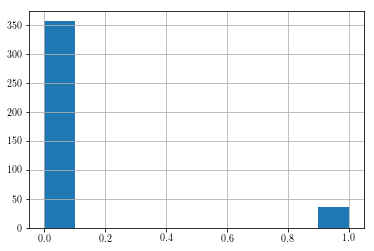

In [8]:
y.hist()

## Step 1 - Choose a Model

We chose a logistic regression model to start because it's simple and is suited to handle binary response variable (instead of a continuous one, for which one should use a multiple linear regression)

In [9]:
logreg = linear_model.LogisticRegression(C=1e5)

## Train the model with Cross Validation

1. Split data into 80% training and 20% testing set, maintaining the same ratio of response values in each
2. Build model on training data
3. Apply model to testing data
4. Compare results from application on testing data to real values for that testing data

5. Do this for multiple trials of splitting your data (this is the cross-validation part, done to get more statistical power)

In [10]:
predicted = cross_validation.cross_val_predict(logreg, X, y, cv=10)

In [11]:
print(metrics.accuracy_score(y, predicted))

0.918987341772


In [12]:
classification_results = metrics.classification_report(y, predicted)
print(classification_results)

             precision    recall  f1-score   support

      False       0.93      0.98      0.96       358
       True       0.65      0.30      0.41        37

avg / total       0.90      0.92      0.91       395

